# Tutorial: Integration of DLPFC Spatial Transcriptomics Data

In this tutorial, we demonstrate the integration of spatial transcriptomics data using the AugGCL model. We perform experiments on the DLPFC (dorsolateral prefrontal cortex) dataset, which includes both gene expression and spatial location information. The goal is to evaluate the performance of AugGCL in capturing spatial domains and gene expression patterns.

The AugGCL model is built on the PyTorch framework and is optimized for GPU usage, specifically tested on an NVIDIA A6000 GPU. This tutorial will guide you through the steps of data processing, model training, and result visualization for spatial transcriptomics analysis.


### Step 1: Import Necessary Libraries

In this step, we import all the essential libraries required for data processing, model training, and evaluation. These libraries include tools for image processing, deep learning, mathematical operations, and performance evaluation.


In [ ]:
# Import necessary libraries
import os
import cv2
import torch
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import scanpy as sc
from train_AugGCL import train_img
from transModel import TransGene, TransImg
from utils import Transfer_img_Data, Transfer_Data, seed_everything
from utils import Cal_Spatial_Net, Stats_Spatial_Net
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

### Step 2: Load and Preprocess Data

In this step, we load the DLPFC dataset and preprocess it by normalizing gene expression values and identifying highly variable genes. The preprocessing steps are crucial to ensure that the model works with high-quality data, enabling accurate analysis and feature extraction.


In [39]:
# Load and preprocess data
seed_everything(262)
adata = sc.read('./dataset/DLPFC/151507/sampledata.h5ad')
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000, check_values=False)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print(adata)

AnnData object with n_obs × n_vars = 4226 × 18409
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'


### Step 3: Clean and Convert Layer Labels to Numeric Values

In this step, we clean the layer labels in the DLPFC dataset and convert each layer name to a corresponding numeric value. This process helps us better understand the distribution of cell types and allows the model to train based on these numeric labels.


In [41]:
# Extract image patches for spatial coordinates.
img = cv2.imread('./dataset/DLPFC/151507/spatial/full_image.tif')
transform = transforms.ToTensor()
img = transform(img)

patchs = []
for coor in adata.obsm['spatial']:
    py, px = coor
    img_p = img[:, px-25:px+25, py-25:py+25].flatten()
    patchs.append(img_p)
patchs = np.stack(patchs)
df = pd.DataFrame(patchs, index=adata.obs.index)

adata.obsm['imgs'] = df

### Step 4: Build Spatial Graph from Cell Distances

In this step, we construct a spatial graph based on the distances between cells. By calculating the spatial relationships between cells, we can better capture the spatial structure of the tissue. This allows the model to incorporate spatial information into its analysis and improve the performance of downstream tasks.


In [42]:
# Build spatial graph from cell distances.
Cal_Spatial_Net(adata, rad_cutoff= 390,model='Radius')
Stats_Spatial_Net(adata)

------Calculating spatial graph...
The graph contains 121336 edges, 4226 cells.
28.7118 neighbors per cell on average.


/home/super/公共的/jtf/AugGCL/utils.py:236: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/super/公共的/jtf/AugGCL/utils.py:236: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))


### Step 5: Train the AugGCL Model with Image Data

In this step, we train the AugGCL model using the processed data. The model incorporates both gene expression and spatial image data, and we use specific parameters to configure the training process. By training the model, we aim to evaluate its ability to integrate multimodal data for spatial transcriptomics analysis.


In [48]:
adata = train_img(adata, 1.2, 0.8,  hidden_dims=[512, 30], n_epochs=200, lr=0.001,
          random_seed=262, save_path='./checkpoint/10x_train/151507/',
          ncluster=7, use_combine=0, use_img_loss=1)

Size of Input:  (4226, 3000)
./checkpoint/10x_train/151507/init.pth
Model saved successfully!


100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.42it/s]
/home/super/公共的/jtf/AugGCL/train_transformer.py:161: ImplicitModificationWarning: Setting element `.obsm['pred']` of view, initializing view as actual.
  adata_Vars.obsm['pred'] = emb_max.clone().detach().cpu().numpy()


### Step 6: Evaluate Model Performance Using ARI and NMI

In this step, we evaluate the performance of the trained AugGCL model by calculating two widely used metrics for clustering performance: Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI). These metrics help us assess how well the model's clustering matches the ground truth labels.


In [50]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['idx'], obs_df['Ground Truth'])
NMI = normalized_mutual_info_score(obs_df['idx'], obs_df['Ground Truth'])
print('ARI is %.2f'%(ARI))

ARI is 0.68


### Step 7: Visualize Ground Truth and AugGCL Predictions

In this step, we visualize the results of the model's predictions alongside the ground truth labels using spatial plots. The left panel shows the ground truth labels, while the right panel displays the model's predicted clustering. Additionally, we visualize the expression of a specific gene (e.g., `MALAT1`) for both the raw and reconstructed data.


/tmp/ipykernel_451524/2361225348.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  ax = sc.pl.spatial(adata, color=['Ground Truth'],ax=ax_list[0], title=['Ground Truth'], show=False)
/tmp/ipykernel_451524/2361225348.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  ax = sc.pl.spatial(adata, color=['idx'],ax=ax_list[1], title=['AugGCL (ARI=%.2f)' % (ARI)], show=False)


<function matplotlib.pyplot.show(close=None, block=None)>

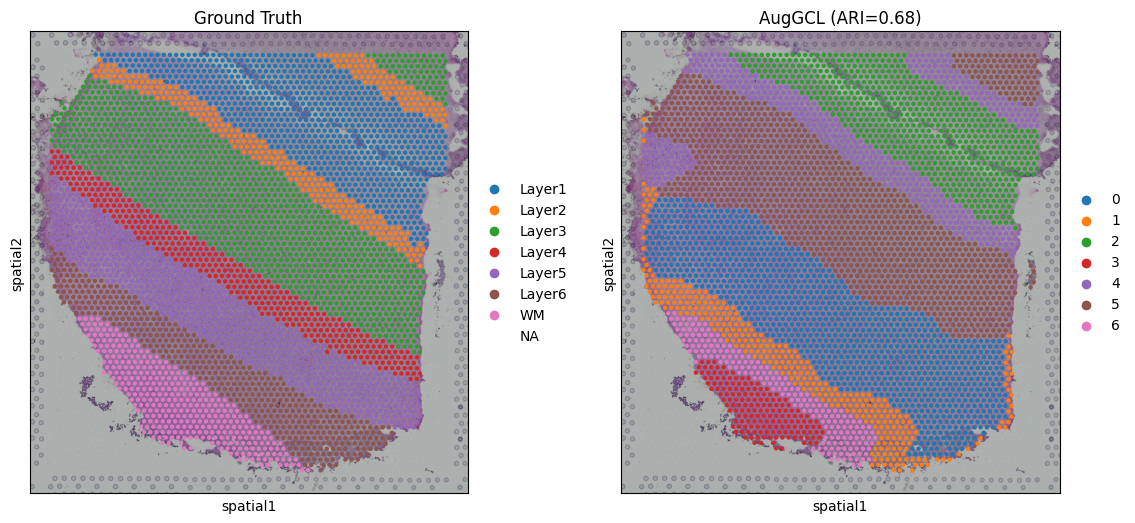

In [61]:
fig, ax_list = plt.subplots(1, 2, figsize=(14, 6))
ax = sc.pl.spatial(adata, color=['Ground Truth'],ax=ax_list[0], title=['Ground Truth'], show=False)
ax = sc.pl.spatial(adata, color=['idx'],ax=ax_list[1], title=['AugGCL (ARI=%.2f)' % (ARI)], show=False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

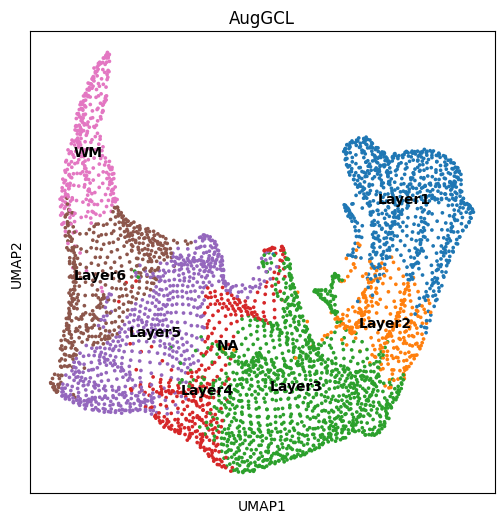

In [62]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='pred')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (6, 6)
ax = sc.pl.umap(adata, color=['Ground Truth'], show=False, title='AugGCL', legend_loc='on data')
plt.show

/tmp/ipykernel_451524/3596660782.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, title="Raw_" + plot_gene, vmax='p99',ax=axs[0])
/tmp/ipykernel_451524/3596660782.py:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, title="AugGCL_" + plot_gene,layer='recon', vmax='p99', ax=axs[1])


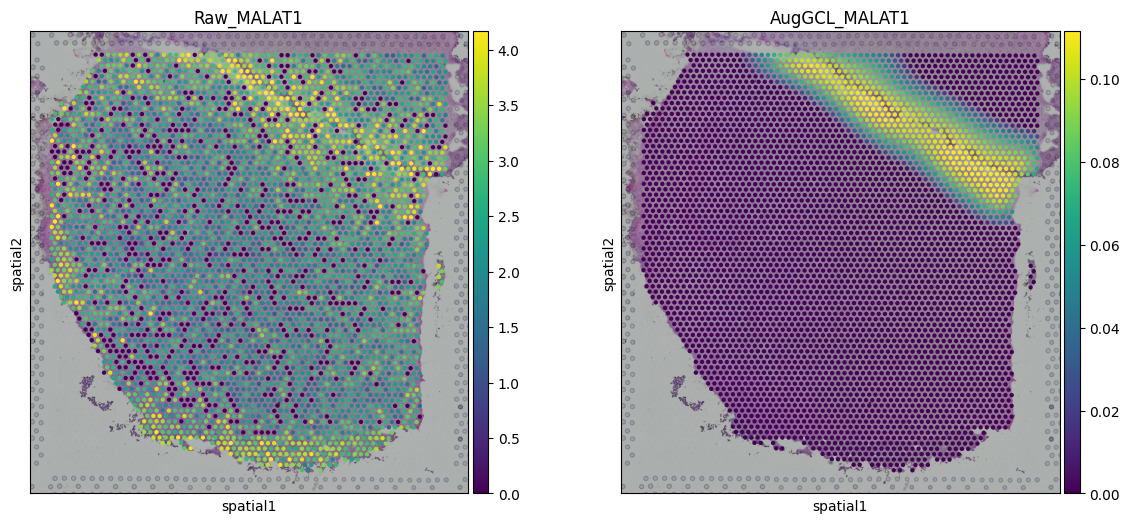

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plot_gene = 'MALAT1'
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, title="Raw_" + plot_gene, vmax='p99',ax=axs[0])
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, title="AugGCL_" + plot_gene,layer='recon', vmax='p99', ax=axs[1])
plt.show()